# Evolving Cellular Automata



In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
plt.style.use('seaborn-deep')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Parameters
R = 3  # size of neighbourhood
N_RULES = 2 ** (2 * R + 1)  #  number of rules in a ruleset
N = 79  # universe length

In [3]:
def uniform_random_binary(length, lower_bound=0, upper_bound=None):
    """
    Generates a random binary string of a given length, sampled uniformly over
    the density of ones.

    :param length: desired length of output binary string
    :type length: int
    :param lower_bound: the lower bound (inclusive) of the number of 1s present,
                        defaults to 0.
    :param upper_bound: the upper bound (exclusive) of the number of 1s present.
    :return: binary string
    :rtype: str
    """
    if upper_bound is None:
        # Default is the length (i.e all 1s)
        upper_bound = length

    n_ones = random.randrange(lower_bound, upper_bound)
    binary = ["1"] * n_ones + ["0"] * (length - n_ones)
    random.shuffle(binary)
    return "".join(binary)

In [4]:
def rule_keys(n_rules, radius=3):
    """
    Generate the keys for the ruleset (i.e incrementing binary strings)
    :param n_rules: the number of rules
    :type n_rules: int
    :return: rule keys
    :rtype: list
    """
    return [str(bin(i))[2:].zfill(2*radius + 1) for i in range(n_rules)]

In [5]:
def single_iteration(config, ruleset, radius):
    """
    Iterate a cellular automaton once as per the ruleset.

    :param config: input configuration
    :type config: str
    :param ruleset: given ruleset mapping all possible binary strings to 0 or 1.
    :type ruleset: dict
    :param radius: number of neighbours on either side
    :type radius: int
    :return: the next iteration of the configuration given the ruleset
    :rtype: str
    """
    next_iteration = ""
    extended_config = config[-radius:] + config + config[:radius]
    
    for i in range(radius, len(config) + radius):
         next_iteration += ruleset[extended_config[i-radius:i + radius+1]]
    return next_iteration



def iterate_automata(initial, ruleset, n_iter, radius=3, verbose=False):
    """
    Iterate an automaton many times

    :param initial: initial config
    :type initial: str
    :param ruleset: given ruleset mapping all possible binary strings to 0 or 1.
    :type ruleset: dict
    :param n_iter: number of iterations
    :type n_iter: int
    :param radius: number of neighbours on either side
    :type radius: int
    :return: the history, i.e the binary string at each iteration
    :rtype: list
    """
    config = initial
    history = [config]
    for _ in range(n_iter):
        config = single_iteration(config, ruleset, radius)
        if verbose:
            print(config)
        history.append(config)
    return history

In [6]:
def plot_spacetime_diagram(binary_history, filename=None):
    """
    Generate a spacetime diagram for a given cellular automaton

    :param binary_history: list of binary strings corresponding to CA's history
    :type binary_history: list
    """
    arr = np.array([[int(digit) for digit in row] for row in binary_history])
    plt.figure()
    plt.imshow(arr, cmap="Purples")
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename, dpi=300)

## The majority ruleset

In this case, each cell sets its next state to whatever the majority is in its neighbourhood of 7 cells (including itself). This does not give good results, as the cells are unable to transfer their knowledge to other parts of the universe. 

In [7]:
# Defining the ruleset
majority_ruleset = {}
for rule_input in rule_keys(N_RULES):
    # 1 if the majority of the neighbourhood is 1.
    rule_value = int((sum(digit == "1" for digit in rule_input) > R))
    majority_ruleset.update({rule_input: str(rule_value)})

0101001110101001101111110100110100000001011001001000101101010111100111010101101
41


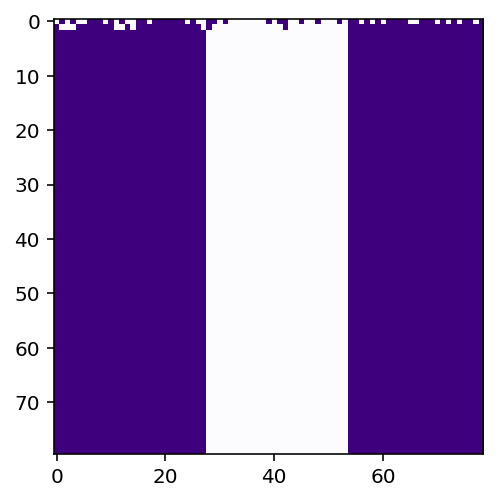

In [8]:
# Iterating
random.seed(7)
initial_config = uniform_random_binary(N)
print(initial_config)
print(sum(i == "1" for i in initial_config))
majority_history = iterate_automata(initial_config, majority_ruleset, n_iter=N, radius=R)
plot_spacetime_diagram(majority_history)

## Genetic algorithms

In [9]:
def random_ruleset(n_rules):
    """
    Combine rule keys with random binary strings to form random rulesets

    :param n_rules: the number of rules
    :type n_rules: int
    :return: a hexadecimal ID, and a ruleset (mapping between rule key and 0 or 1)
    :rtype: str, dict
    """
    rule_values = uniform_random_binary(n_rules)
    hex_id = hex(int(rule_values, 2))
    return hex_id, dict(zip(rule_keys(n_rules), rule_values))

def random_ruleset2(n_rules):
    """
    Combine rule keys with random binary strings to form random rulesets

    :param n_rules: the number of rules
    :type n_rules: int
    :return: a hexadecimal ID, and a ruleset (mapping between rule key and 0 or 1)
    :rtype: str, dict
    """
    rule_values = str(bin(random.randint(0, 2**n_rules - 1)))[2:].zfill(n_rules)
    hex_id = hex(int(rule_values, 2))
    return hex_id, dict(zip(rule_keys(n_rules), rule_values))


def generate_random_ICs(universe_size, n_ic, p_c=0.5):
    """
    Generate random initial conditions (binary strings), with exactly half having
    a minority of 1s and the other half having a majority of 1s.

    :param universe_size: length of universe (N)
    :type universe_size: int
    :param n_ic: number of random initial conditions to setup (N_IC)
    :type n_ic: int
    :param p_c: cutoff proportion to be considered a majority (P_C)
    :type p_c: float
    """
    all_init_conds = []
    cutoff = int(p_c * universe_size) + 1
    # Exactly half of the initial conditions will have p < p_c
    for _ in range(n_ic // 2):
        all_init_conds.append(uniform_random_binary(universe_size, 0, cutoff))
        all_init_conds.append(
            uniform_random_binary(universe_size, cutoff, universe_size + 1)
        )
    return all_init_conds

In [10]:
def hex_to_ruleset(hex_id, n_rules=128):
    """
    Given a hex_id, convert it to a ruleset
    """
    rule_values = bin(int(hex_id, 16))[2:].zfill(n_rules)
    return dict(zip(rule_keys(n_rules), rule_values))

def crossover_and_mutate(hex1, hex2, n_rules=128, n_crossover_points=1, n_mutations=2):
    """
    :param hex1: first parent
    :param hex2: second parent
    :param n_rules: number of rules in the rulesets
    :param n_crossover_points: number of pointwise crossovers
    :param n_mutations: number of pointwise mutations
    """
    bin1 = list(bin(int(hex1, 16))[2:].zfill(n_rules))
    bin2 = list(bin(int(hex2, 16))[2:].zfill(n_rules))
    # Single point crossover – get indices of unequal, then randomly select
    unequal_indices = [i for i, digit in enumerate(bin1) if bin2[i] != digit]
    if len(unequal_indices) > n_crossover_points:
        crossover_points = random.sample(unequal_indices, n_crossover_points)
        for c in crossover_points:
            bin1[c] = bin2[c]
    # Mutation
    for _ in range(n_mutations):
        idx = random.randrange(n_rules)
        bin1[idx] = str(int(not bool(bin1[idx])))
    return hex(int("".join(bin1),2))


In [ ]:
N = 59  # universe size
MAX_ITER = 100  # maximum iterations per CA
N_CHROMOSOMES = 100  # number of different rulesets in the initial population
GEN = 50  # number of generations
N_IC = 100  # number of initial conditions to test a rule on

random.seed(0)
population = {}
for _ in range(N_CHROMOSOMES):
    id, ruleset = random_ruleset2(N_RULES)
    population[id] = ruleset
    
generation_best_performers = []
all_fitnesses = []

for gen in range(GEN):
    print("\nGen", gen, "\n==========")

    # Generate random initial conditions to test chromosomes
    generation_ics = generate_random_ICs(N, N_IC)
    fitness_log = []

    for hex_id, chromosome in population.items():
        # For each chromosome, evaluate performance on random ICs.
        fitness = 0
        for config in generation_ics:
            majority = config.count("1") > len(config) // 2
            hist = iterate_automata(config, chromosome, MAX_ITER, verbose=False)
            if hist[-1] == str(int(majority)) * len(config):
                fitness += 1
        print("hex_id", hex_id, "  Fitness", fitness)
        fitness_log.append((hex_id, fitness))
    all_fitnesses.append(fitness_log)
    generation_best_performers.append(fitness_log[0][0])

    # Copy the top 20 to the next generation
    new_population = {}
    for i in elites:
        new_population[i] = hex_to_ruleset(i)

    # Generate the offspring from randomly selected pairs of elites
    for _ in range(N_CHROMOSOMES - 20):
        parent1, parent2 = random.sample(elites, 2) 
        child_hex = crossover_and_mutate(parent1, parent2, n_crossover_points=1, n_mutations=15)
        new_population[child_hex] = hex_to_ruleset(child_hex)

    population = new_population

## Refactor and save

Because of the time it takes for a single run of the genetic algorithm, and the need for having multiple runs, I refactored the genetic algorithm into a function, which pickles the results for later analysis. This way, I can conduct something like 40 runs overnight. 

In [11]:
def evolve_automata(universe_size=59, n_crossover_points=1, n_mutations=2, 
                    random_seed=None, n_ic=100, n_gen=100, ruleset_generator=2):
    
    random.seed(random_seed)
    population = {}
    for _ in range(N_CHROMOSOMES):
        if ruleset_generator == 2:
            id, ruleset = random_ruleset2(N_RULES)
        else:
            id, ruleset = random_ruleset(N_RULES)
        population[id] = ruleset

    all_ics = [generate_random_ICs(universe_size, n_ic) for _ in range(n_gen)]
    generation_best_performers = []
    all_fitnesses = []

    for gen in range(n_gen):
        print("\nGen", gen, "\n==========")

        # Generate random initial conditions to test chromosomes
        generation_ics = all_ics[gen]
        fitness_log = []

        for hex_id, chromosome in population.items():
            # For each chromosome, evaluate performance on random ICs.
            fitness = 0
            for config in generation_ics:
                majority = config.count("1") > len(config) // 2
                hist = iterate_automata(config, chromosome, MAX_ITER, verbose=False)
                if hist[-1] == str(int(majority)) * len(config):
                    fitness += 1
            print("hex_id", hex_id, "  Fitness", fitness)
            fitness_log.append((hex_id, fitness))

        all_fitnesses.append(fitness_log)

        # Find top 20 in population
        fitness_log.sort(key=lambda x: x[1], reverse=True)
        elites = [i[0] for i in fitness_log[:20]]

        print("Generation best:", fitness_log[0])
        print("Least fit elite:", fitness_log[20])

        # Copy the top 20 to the next generation
        new_population = {}
        for i in elites:
            new_population[i] = hex_to_ruleset(i)

        # Generate the offspring from randomly selected pairs of elites
        for _ in range(N_CHROMOSOMES - 20):
            parent1, parent2 = random.sample(elites, 2) 
            child_hex = crossover_and_mutate(parent1, parent2, 
                                             n_crossover_points=n_crossover_points, 
                                             n_mutations=n_mutations)
            new_population[child_hex] = hex_to_ruleset(child_hex)

        population = new_population
        
    filename = f"ca_pickles/N{universe_size}C{n_crossover_points}" + \
               f"M{n_mutations}S{random_seed}G{n_gen}R{ruleset_generator}.pickle" 
    with open(filename, "wb") as output_file:
        pickle.dump((all_ics, all_fitnesses), output_file)
    
    return all_fitnesses, all_ics

In [ ]:
# for r in range(20):
#     evolve_automata(59, n_crossover_points=1, n_mutations=6, random_seed=r, n_ic=100, n_gen=50, 
#                         ruleset_generator=1)
    
# for r in range(20, 50):
#     evolve_automata(59, n_crossover_points=1, n_mutations=6, random_seed=r, n_ic=100, n_gen=50)
    
# for r in range(20):
#     evolve_automata(59, n_crossover_points=1, n_mutations=12, random_seed=r, n_ic=100, n_gen=50)
    
# for r in range(3, 20):
#     evolve_automata(59, n_crossover_points=1, n_mutations=18, random_seed=r, n_ic=100, n_gen=50)

# for r in range(10):
#     evolve_automata(149, n_crossover_points=1, n_mutations=2, random_seed=r, n_ic=100, n_gen=80)
    

for r in range(10):
    evolve_automata(59, n_crossover_points=4, n_mutations=12, random_seed=r, n_ic=100, n_gen=50)


## Analysis of hyperparameters

In [76]:
import os

avl_pickles = os.listdir("ca_pickles/")
m6_r1 = [i for i in avl_pickles if "M6" in i and "R1" in i]
m6_r2 = [i for i in avl_pickles if "M6" in i and "R2" in i]
m12 = [i for i in avl_pickles if "M12" in i]
m18 = [i for i in avl_pickles if "M18" in i]

In [77]:
def analyse_runs(input_pickles):
    mean_fitnesses = []
    for file in input_pickles:
        try:
            with open("ca_pickles/"+file, "rb") as infile:
                ics, fitnesses = pickle.load(infile)
        except:
            continue
        # Calculate the mean of the mean elite fitness over the last 10 generations.
        total = 0
        for gen_fitness_log in fitnesses[-10:]:
            # Get the generation elites
            gen_fitness_log.sort(key=lambda x: x[1], reverse=True)
            gen_elites = [i[1] for i in gen_fitness_log[:20]]
            # Mean of the elites for the last 10 generations
            total += sum(gen_elites) /20

        mean = total/10
        mean_fitnesses.append(mean)
        seed = file.split('S')[1].split('G')[0]
        print(f"Seed {seed}: {mean:.1f}")

    return mean_fitnesses

In [78]:
print("N_MUTATIONS=6, R1 \n=================")
res = analyse_runs(m6_r1)
print(sum(r > 55 for r in res), "have fitness higher than 55%")

print("N_MUTATIONS=6, R2 \n=================")
res = analyse_runs(m6_r2)
print(sum(r > 55 for r in res), "have fitness higher than 55%")

print("\nN_MUTATIONS=12 \n==============")
res = analyse_runs(m12)
print(sum(r > 55 for r in res), "have fitness higher than 55%")

print("\nN_MUTATIONS=18 \n==============")
res = analyse_runs(m18)
print(sum(r > 55 for r in res), "have fitness higher than 55%")

N_MUTATIONS=6, R1 
Seed 0: 52.0
Seed 19: 74.7
Seed 9: 51.8
Seed 10: 51.4
Seed 15: 91.0
Seed 5: 51.0
Seed 6: 74.9
Seed 16: 79.7
Seed 13: 92.2
Seed 3: 62.7
Seed 4: 51.2
Seed 14: 51.5
Seed 11: 81.6
Seed 8: 51.3
Seed 18: 78.6
Seed 1: 51.2
Seed 2: 52.0
Seed 12: 52.0
Seed 17: 52.0
Seed 7: 52.0
8 have fitness higher than 55%
N_MUTATIONS=6, R2 
Seed 8: 83.5
Seed 23: 50.7
Seed 11: 52.2
Seed 1: 92.6
Seed 18: 51.2
Seed 4: 51.1
Seed 26: 51.7
Seed 14: 50.0
Seed 17: 51.5
Seed 25: 51.4
Seed 30: 50.0
Seed 7: 51.5
Seed 29: 89.9
Seed 2: 51.7
Seed 12: 79.2
Seed 20: 51.5
Seed 15: 83.1
Seed 27: 52.0
Seed 5: 51.7
Seed 19: 73.5
Seed 0: 57.2
Seed 10: 51.6
Seed 9: 51.2
Seed 22: 82.3
Seed 21: 51.0
Seed 13: 52.1
Seed 28: 56.3
Seed 3: 50.0
Seed 6: 78.7
Seed 24: 51.8
Seed 16: 82.9
11 have fitness higher than 55%

N_MUTATIONS=12 
Seed 9: 51.2
Seed 16: 80.2
Seed 0: 57.2
Seed 13: 79.9
Seed 5: 51.7
Seed 19: 51.8
Seed 6: 75.9
Seed 10: 51.6
Seed 3: 51.6
Seed 15: 75.8
Seed 4: 51.1
Seed 12: 50.0
Seed 1: 51.6
Seed 17: 51.5

## Analysis of evolved CAs

In [85]:
with open('ca_pickles/N59C1M6S1G50R2.pickle', 'rb') as infile:
    ics, fitnesses = pickle.load(infile)

fittest = fitnesses[-1][0][0]
fittest_ruleset = hex_to_ruleset(fittest)
last_configs = ics[-1]

In [203]:
fittest

'0x41101250500005104304c031543c1ff'

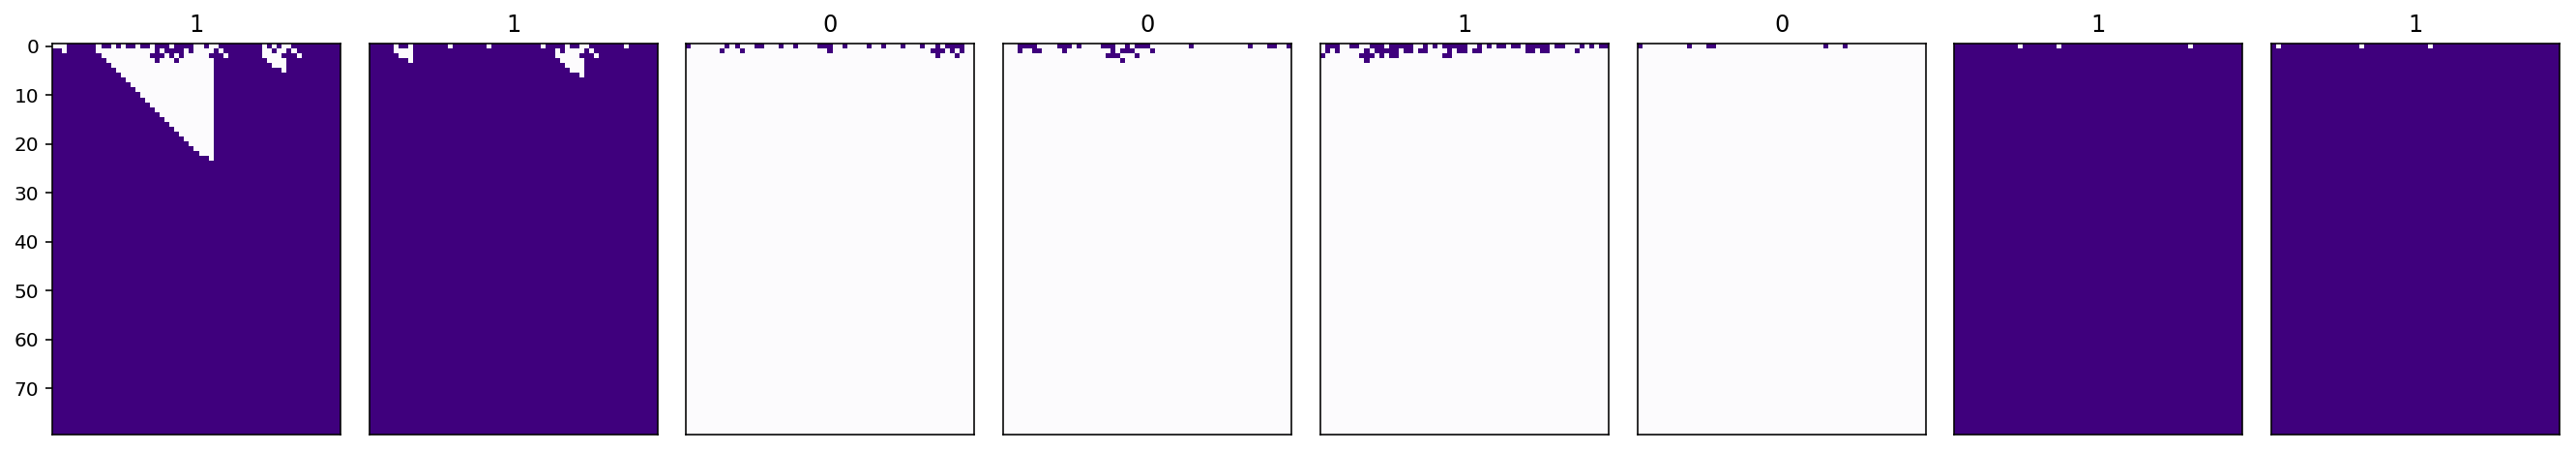

In [204]:
n_subplots = 8
plt.subplots(1, n_subplots, figsize=(20, 4))
plt.tight_layout()

random.seed(2)

for counter, idx in enumerate(random.sample(range(100), n_subplots)): 
    plt.subplot(1, n_subplots, counter + 1)
    initial_config = last_configs[idx]
    history = iterate_automata(initial_config, fittest_ruleset, n_iter=N)
    arr = np.array([[int(digit) for digit in row] for row in history])
    majority = max(set(initial_config), key=initial_config.count)
    plt.title(majority)
    plt.imshow(arr, cmap="Purples")
    plt.xticks([])
    if counter != 0:
        plt.yticks([])

plt.subplots_adjust(left=0.05, right=0.95, wspace=0.1)
plt.show()
# plt.savefig("analysis.png", dpi=300)